In [12]:
import ujson
import os
from os.path import join
from collections import Counter

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
import keras
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [403]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, log_loss

In [17]:
from random import shuffle, randint
import pandas as pd

In [18]:
file_format = "train_{}.json"

In [19]:
DATADIR = "/workspace/data/bots/turing-data/"

In [20]:
#0.62

In [278]:
TRAIN_DATA = join(DATADIR, file_format.format("20170724"))
TEST_DATA = join(DATADIR, file_format.format("20170725"))

In [279]:
TRAIN_DATA

'/workspace/data/bots/turing-data/train_20170724.json'

In [280]:
train_data = ujson.load(open(TRAIN_DATA))
test_data = ujson.load(open(TEST_DATA))

In [306]:
for r in get_replies(train_data[2], "Bob"):
    print(r["text"])

Who uses the four stages of civil society ?
Ehh its incorrect. Hint: first 3 answer letters is "fer" 
What
Please, speak with me.
Please, speak with me. It gives me energy to live


In [377]:
def get_score(diag, user):
    score = list(filter(lambda x: x["userId"] != user, diag["evaluation"]))[0]["quality"]
    score = 1 if score >= 2 else 0
    return score

In [479]:
train_data[2]

{'context': 'Though much of Enlightenment political thought was dominated by social contract theorists, both David Hume and Adam Ferguson criticized this camp. Hume\'s essay Of the Original Contract argues that governments derived from consent are rarely seen, and civil government is grounded in a ruler\'s habitual authority and force. It is precisely because of the ruler\'s authority over-and-against the subject, that the subject tacitly consents; Hume says that the subjects would "never imagine that their consent made him sovereign", rather the authority did so. Similarly, Ferguson did not believe citizens built the state, rather polities grew out of social development. In his 1767 An Essay on the History of Civil Society, Ferguson uses the four stages of progress, a theory that was very popular in Scotland at the time, to explain how humans advance from a hunting and gathering society to a commercial and civil society without "signing" a social contract.',
 'dialogId': -155769874,
 

In [378]:
def get_replies(diag, user):
    replies = list(filter(lambda x: x["userId"] == user, diag["thread"]))
    return replies

In [493]:
def get_type(diag, user):
    u = list(filter(lambda x: x["id"] == user, diag["users"]))[0]['userType']
    return 1 if u == "Bot" else 0

In [494]:
def make_features(diags, labeled=False):
    observations = []
    
    for d in diags:
        
        for name in ["Alice", "Bob"]:
            
            replies = get_replies(d, name)
            
            if len(replies) > 0:
                    
                obs = {}
                obs["reply"] = "$".join([r["text"] for r in replies])
                obs["pos"] = i
                obs["user"] = name
                obs["dialogId"] = d["dialogId"]
                if labeled:
                    obs["label"] = get_score(d, name)
                    obs["userType"] = get_type(d, name)
                observations.append(obs)
    
    return pd.DataFrame(observations)

In [495]:
shuffle(train_data)
shuffle(test_data)
df_train = make_features(train_data, True)
df_test = make_features(test_data, True)

In [496]:
len(df_train)

585

In [497]:
def get_vocab(data):
    vocab = Counter()
    for r in data.iterrows():
        vocab.update(r[1]["reply"])
    return vocab

In [498]:
vocab = get_vocab(df_train)

In [499]:
len(vocab)

180

In [500]:
char_to_ind = {c[0]: i + 1 for i, c in enumerate(vocab.most_common())}
ind_to_char = {i: c for c, i in char_to_ind.items()}

In [501]:
def text_to_seq(text, char_to_ind):
    return [char_to_ind.get(c, 0) for c in text]

In [526]:
MAX_PAD = 200

In [527]:
def add_sequences(df, char_to_ind):
    df["seq"] = df.reply.apply(lambda x: text_to_seq(x, char_to_ind))
    df["seq_len"] = df["seq"].apply(len)
    df["seq_padded"] = df["seq"].apply(lambda x: sequence.pad_sequences([x], MAX_PAD, padding="post"))
    return df

In [565]:
df_train = add_sequences(df_train, char_to_ind)
df_test = add_sequences(df_test, char_to_ind)

In [583]:
y_train_score = df_train["label"].values
y_test_score = df_test["label"].values

In [585]:
y_train_bot = df_train["userType"].values
y_test_bot = df_test["userType"].values

In [586]:
# plt.hist(y_train, bins=100)
# plt.show()

In [587]:
x_train = np.vstack(df_train["seq_padded"].values)
x_test = np.vstack(df_test["seq_padded"].values)

In [739]:
EMB_SIZE = 64
H_SIZE = 64

In [771]:
def get_chat_model(n_words=MAX_PAD,
                  vocab_len=len(char_to_ind) + 1,
                  emb_size=EMB_SIZE,
                  h_size=H_SIZE,
                  weights=None):
    
    reply = Input(shape = (n_words,), name='n_reply')
    reply_e = Embedding(vocab_len, emb_size)(reply)
    
    x = Conv1D(h_size, 4, activation='relu', strides=1)(reply_e)    
    xg = GlobalMaxPooling1D()(x)
    
    x = Dense(8, activation="linear")(xg)
    x = Dropout(0.1)(x)
    metric = Dense(1, activation="linear", name="metric")(x)
    
    y = Dense(8, activation="relu")(xg)
    y = Dropout(0.1)(y)
    bot = Dense(1, activation="sigmoid", name="bot")(y)
    
    model = Model(inputs=[reply], outputs=[metric, bot])
    
    model.compile(loss={"metric": "mse", "bot": "binary_crossentropy"},
                  optimizer=Adam(0.0001), metrics=["accuracy"], loss_weights={"metric": 1, "bot": 10})
    
    if weights:
        model.load_weights(weights)
    
    return model

In [772]:
checkpoint_cb = ModelCheckpoint(
    filepath="/workspace/data/bots/chat_model_weights_1_.{epoch:02d}-{val_loss:.5f}-{val_acc:.5f}.hdf5",
    save_weights_only=True)

In [773]:
model = get_chat_model()

In [774]:
N_EPOCHS = 50

In [775]:
mse_train_l = []
mse_test_l = []
sr_train_l = []
sr_test_l = []
bot_train_l = []
bot_test_l = []
for i in range(N_EPOCHS):
    print(i)
    model.fit(x_train, [y_train_score, y_train_bot], batch_size=16, epochs=1, verbose=0)
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)
    sr_train = spearmanr(train_preds[0], y_train_score)
    sr_train_l.append(sr_train.correlation)
    sr_test = spearmanr(test_preds[0], y_test_score)
    sr_test_l.append(sr_test.correlation)
    
    mse_train = mean_squared_error(train_preds[0], y_train_score)
    mse_test = mean_squared_error(test_preds[0], y_test_score)
    mse_train_l.append(mse_train)
    mse_test_l.append(mse_test)
    
    ll_train = mean_squared_error(train_preds[1], y_train_bot)
    ll_test = mean_squared_error(test_preds[1], y_test_bot)
    bot_train_l.append(ll_train)
    bot_test_l.append(ll_test)
   
    print("mse: train: {}, test: {}".format(mse_train, mse_test))
    print("sr: train: {}, test: {}".format(sr_train.correlation, sr_test.correlation))
    print("ll: train: {}, test: {}".format(ll_train, ll_test))

0
mse: train: 0.5292192536224828, test: 0.3690734257498498
sr: train: -0.01740944011550958, test: 0.06561043727431924
ll: train: 0.23459915666300815, test: 0.24120753576849926
1
mse: train: 0.3557184638533588, test: 0.2539119081155209
sr: train: 0.21388600840152924, test: 0.2998499271423231
ll: train: 0.20938920438181052, test: 0.22863373556685973
2
mse: train: 0.27856283996383874, test: 0.21827166201685222
sr: train: 0.26367357491992105, test: 0.334627842668577
ll: train: 0.18625895053469566, test: 0.21930400660390612
3
mse: train: 0.24202808963159417, test: 0.216252966739191
sr: train: 0.28544797536686295, test: 0.3382809850557885
ll: train: 0.17197079235226106, test: 0.2154242176814643
4
mse: train: 0.23017726606788122, test: 0.2272639738831541
sr: train: 0.29741893123385144, test: 0.34156881320427895
ll: train: 0.16102469677263698, test: 0.21441453714723796
5
mse: train: 0.22779741137979492, test: 0.23389572057462168
sr: train: 0.3065134991831864, test: 0.3409843104223251
ll: train

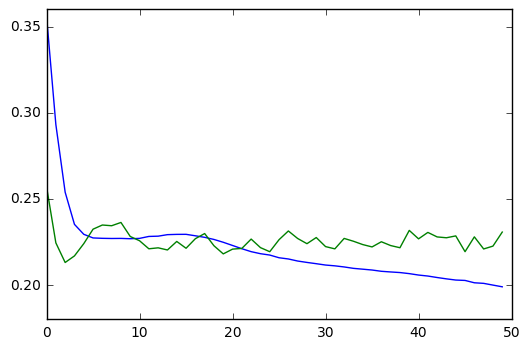

In [767]:
plt.plot(mse_train_l)
plt.plot(mse_test_l)
plt.show()

In [768]:
max(sr_test_l)

0.42354532837330588

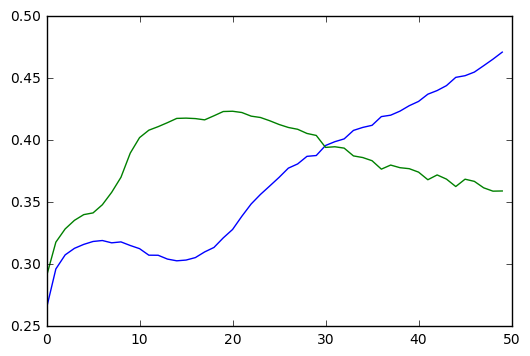

In [769]:
plt.plot(sr_train_l)
plt.plot(sr_test_l)
plt.show()

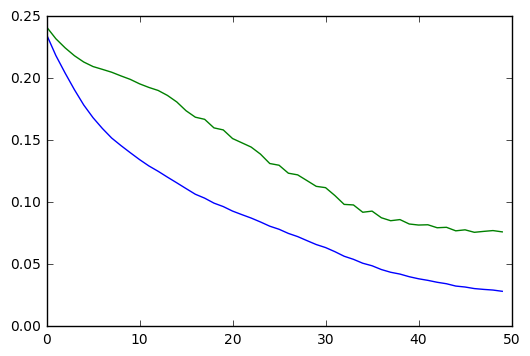

In [770]:
plt.plot(bot_train_l)
plt.plot(bot_test_l)
plt.show()

In [776]:
model.save_weights("/workspace/mount/bots/bots_model.h5")